In [27]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [46]:
#lendo o arquivo BRAS.csv
#O arquivo utilizado foi baixado do site www.football-data.co.uk, que agrega informações de diversos campeonatos
#ao redor do mundo.

data=pd.read_csv('BRA.csv',delimiter=',')

#cria um data frame dimensão somente com os nome dos times
equipes = pd.DataFrame(data, columns=['Home'])

#ordenando os valores
equipes.sort_values('Home', inplace = True)
 
#elimina todos os valores duplicados
equipes = equipes.drop_duplicates(subset='Home', keep='first')

#cria coluna para identificação dos times
equipes.insert(0,'id_time',equipes.index,allow_duplicates=False)

#verifica o resultado do data frame
display(equipes.head())

#Verificando as 5 primeiras linhas do arquivo a ser utilizado
display(data.head())

#Notes for football data

#Country = país do campeonato
#League = nome da liga
#game_id = id do jogo
#Season = temporada
#date = data do jogo
#Time = hora do jogo
#Home = Time da casa
#home_id = id do time da casa
#Away = time visitante
#Away_id =  id do time visitante
#HG = Gols do time da casa
#AG = Gols do time visitante
#Res = Resultado do jogo (D=Draw, H=Home win, A=Away win)
#PH = probablidade vitória time da casa provida pela Pinacle (casa de aposta inglesa)
#PD = probablidade empate provida pela Pinacle (casa de aposta inglesa)
#PA = probablidade vitória time visitante provida pela Pinacle (casa de aposta inglesa)
#MaxH = probablidade vitória time da casa provida pela OddsPortal (casa de aposta inglesa)
#MaxD = probablidade empate provida pela OddsPortal (casa de aposta inglesa)
#MaxA = probablidade vitória time visitante provida pela OddsPortal (casa de aposta ingles
#AvgH = probablidade média de vitória em casa provida pela OddsPortal (casa de aposta inglesa)
#AvgD = probablidade média de empate provida pela OddsPortal (casa de aposta inglesa)
#AvgA = probablidade média de vitória pelo time visitante provida pela OddsPortal (casa de aposta inglesa)

,id_time,Home
3730,3730,America MG
3707,3707,Athletico-PR
3262,3262,Atletico GO
3059,3059,Atletico-MG
968,968,Atletico-PR


,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [29]:
#Explorando os dados
#Base de dados de dos campeonatos de 2012 a 2022

#substituindo os valores string H, A ou D da coluna Res para valores do tipo
#numéricos onde H = 1 (vitória time da casa)
# A = 2 (vitória time visitante)
# D = 0 (empate)

data['Res'] = data['Res'].map({'H':1,
                               'A':2,
                               'D':0},
                              na_action=None)

matches = data.shape[0]

features = data.shape[1] -1 #Retirando a coluna Resultado

#inseri coluna para identificar os jogos
#o id_jogo será igual ao índice da linha do data frame
data.insert(5,'id_jogo',data.index,allow_duplicates=False)

display(data.head())

home_win = len(data[data.Res==1])
away_win = len(data[data.Res==2])
draw = len(data[data.Res==0])
val=[home_win,away_win,draw]

win_rate = ((home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

#Podemos notar que o "fator casa" é importante , sendo que em quase 50% do jogos são ganhos pelo time da casa.

,Country,League,Season,Date,Time,id_jogo,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,0,Palmeiras,Portuguesa,1.0,1.0,0.0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,1,Sport Recife,Flamengo RJ,1.0,1.0,0.0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,2,Figueirense,Nautico,2.0,1.0,1.0,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,3,Botafogo RJ,Sao Paulo,4.0,2.0,1.0,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,4,Corinthians,Fluminense,0.0,1.0,2.0,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


Total de jogos:  3910
Total de colunas:  18
Total de jogos ganhos em casa:  1907
Total de jogos ganhos pelo visitante:  942
Total de jogos empatados:  1060
Percentual de jogos ganhos em casa: 48.77%


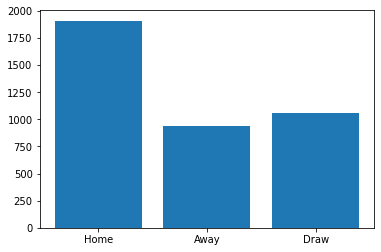

In [15]:
#Visualizando os dados

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Away', 'Draw'))
plt.show()

In [16]:
#Preparando os dados


#Deixar somente as variáveis numericas 
#num_data = data.drop(['Country','League','Season','Date','Time','Home','Away'],1)
num_data = data.drop(['Country','League','Season','Date','Time'],1)

display(num_data.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Palmeiras,Portuguesa,1.0,1.0,0.0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Sport Recife,Flamengo RJ,1.0,1.0,0.0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Figueirense,Nautico,2.0,1.0,1.0,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Botafogo RJ,Sao Paulo,4.0,2.0,1.0,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Corinthians,Fluminense,0.0,1.0,2.0,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [17]:
#separa as features 
features = num_data.drop(['Res'],1)


#separa as labels
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Features
           Home         Away   HG   AG    PH    PD    PA  MaxH  MaxD  MaxA  \
0     Palmeiras   Portuguesa  1.0  1.0  1.75  3.86  5.25  1.76  3.87  5.31   
1  Sport Recife  Flamengo RJ  1.0  1.0  2.83  3.39  2.68  2.83  3.42  2.70   
2   Figueirense      Nautico  2.0  1.0  1.60  4.04  6.72  1.67  4.05  7.22   
3   Botafogo RJ    Sao Paulo  4.0  2.0  2.49  3.35  3.15  2.49  3.39  3.15   
4   Corinthians   Fluminense  0.0  1.0  1.96  3.53  4.41  1.96  3.53  4.41   

   AvgH  AvgD  AvgA  
0  1.69  3.50  4.90  
1  2.59  3.23  2.58  
2  1.59  3.67  5.64  
3  2.35  3.26  2.84  
4  1.89  3.33  3.89  
Labels
0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Res, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [20]:
#Escoolhendo as melhores features com Kbest

features_list = ('Home','Away','HG','AG','PH','PD','PA','MaxH','MaxD','MaxA','AvgH','AvgD','AvgA')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)

ValueError: ignored